# Overview
This notebook shows you how you can train, evaluate, and deploy a propensity model in BigQuery ML to predict user retention on a mobile game, based on app measurement data from Google Analytics 4.



### Dataset

This notebook uses [this public BigQuery dataset](https://console.cloud.google.com/bigquery?p=firebase-public-project&d=analytics_153293282&t=events_20181003&page=table), contains raw event data from a real mobile gaming app called Flood It! ([Android app](https://play.google.com/store/apps/details?id=com.labpixies.flood), [iOS app](https://itunes.apple.com/us/app/flood-it!/id476943146?mt=8)). The [data schema](https://support.google.com/analytics/answer/7029846) originates from Google Analytics for Firebase, but is the same schema as [Google Analytics 4](https://support.google.com/analytics/answer/9358801); this notebook applies to use cases that use either Google Analytics for Firebase or Google Analytics 4 data.

Google Analytics 4 (GA4) uses an [event-based](https://support.google.com/analytics/answer/9322688) measurement model. Events provide insight on what is happening in an app or on a website, such as user actions, system events, or errors. Every row in the dataset is an event, with various characteristics relevant to that event stored in a nested format within the row. While Google Analytics logs many types of events already by default, developers can also customize the types of events they also wish to log.

Note that as you cannot simply use the raw event data to train a machine learning model, in this notebook, you will also learn the important steps of how to pre-process the raw data into an appropriate format to use as training data for classification models.

### Objective and Problem Statement

The goal of this notebook is to provide an end-to-end solution for propensity modeling to predict user churn on GA4 data using BigQuery ML. Using the "Flood It!" dataset, based on a user's activity within the first 24 hrs of app installation, you will try various classification models to predict the propensity to churn (1) or not churn (0).

By the end of this notebook, you will know how to:
* Explore the export of Google Analytics 4 data on BigQuery
* Prepare the training data using demographic, behavioral data, and the label (churn/not-churn)
* Train classification models using BigQuery ML
* Evaluate classification models using BigQuery ML
* Make predictions on which users will churn using BigQuery ML


### Costs

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [6]:
import os
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  vertex-ai-dev


Otherwise, set your project ID here.

In [4]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "your-project-id"  # @param {type:"string"}

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**


{TODO: Adjust wording in the first paragraph to fit your use case - explain how your tutorial uses the Cloud Storage bucket. The example below shows how Vertex AI uses the bucket for training.}

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. Vertex AI runs
the code from this package. In this tutorial, Vertex AI also saves the
trained model that results from your job in the same bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [ ]:
BUCKET_NAME = "gs://[your-bucket-name]"  # @param {type:"string"}
REGION = "[your-region]"  # @param {type:"string"}

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

### Import libraries and define constants

In [51]:
from google.cloud import bigquery
import pandas as pd


### Create a BigQuery dataset

In this notebook, you will need to create a dataset in your project called `bqmlga4`. To create it, run the following cell:

#@bigquery
-- create a dataset in Bigquery

CREATE SCHEMA bqmlga4
OPTIONS(
  location="us"
  )

## The dataset


### Using the sample gaming event data from Flood it!



The sample dataset contains raw event data, as shown in the next cell:



In [1]:
%%bigquery --project 	vertex-ai-dev

SELECT 
    *
FROM
  `firebase-public-project.analytics_153293282.events_*`
    
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  4.57rows/s]


,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions
0,20180907,1536318204637000,level_complete,"[{'key': 'level_name', 'value': {'string_value...",NaN,NaN,12,-1337527,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
1,20180907,1536318185637001,level_up,"[{'key': 'level_name', 'value': {'string_value...",NaN,NaN,12,-1337527,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
2,20180907,1536318212553000,level_complete,"[{'key': 'level_name', 'value': {'string_value...",1.536318e+15,NaN,13,-1326405,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
3,20180907,1536318151553003,level_up,"[{'key': 'level_name', 'value': {'string_value...",1.536318e+15,NaN,13,-1326405,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None
4,20180907,1536318252285000,level_complete,"[{'key': 'level_name', 'value': {'string_value...",1.536318e+15,NaN,14,-1254437,None,E271C38BE1E3E9E9A1D4DE0A5CF3FA3E,"[{'key': 'plays_quickplay', 'value': {'string_...",1536040597598000,None,"{'category': 'mobile', 'mobile_brand_name': 'n...","{'continent': 'Asia', 'country': 'India', 'reg...","{'id': 'com.labpixies.flood', 'version': '2.62...","{'name': None, 'medium': 'organic', 'source': ...",1051193346,ANDROID,None


It may be helpful to take a look at the overall schema used in Google Analytics 4. As mentioned earlier, Google Analytics 4 uses an event based measurement model and each row in this dataset is an event. [Click here](https://support.google.com/analytics/answer/7029846) to view the complete schema and details about each column. As you can see above, certain columns are nested records and contain detailed information:



* `app_info`
* `device`
* `ecommerce`
* `event_params`
* `geo`
* `traffic_source`
* `user_properties`
* `items`*
* `web_info`*

_* present by default in GA4 datasets_

As we can see below, there are 15K users and 5.7M events in this dataset:

#@bigquery
SELECT 
    COUNT(DISTINCT user_pseudo_id) as count_distinct_users,
    COUNT(event_timestamp) as count_events
FROM
  `firebase-public-project.analytics_153293282.events_*`

### Preparing the training data

You cannot simply use raw event data to train a machine learning model as it would not be in the right shape and format to use as training data. So in this section, you will learn how to pre-process the raw data into an appropriate format to use as training data for classification models.


To predict which user is going to _churn_ or _return_, the ideal training data format for classification should look like the following:  


|User ID|User demographic data|User behavioral data|Churned|
|-|-|-|-|
|User1|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|1
|User2|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|0
|User3|(e.g., country, device_type)|(e.g., # of times they did something within a time period)|1


Characteristics of the training data:
- each row is a separate unique user ID
- feature(s) for **demographic data**
- feature(s) for **behavioral data**
- the actual **label** that you want to train the model to predict (e.g., 1 = churned, 0 = returned)

You can train a model with only demographic data or behavioral data, but having a combination of both will likely help you create a more predictive model. For this reason, in this section, you will learn how to pre-process the raw data to follow this training data format.

The following sections will walk you through preparing the demographic data, behavioral data, and the label before joining them all together as the training data.

1. Identifying the label for each user (churned or returned)
1. Extracting demographic data for each user
1. Extracting behavioral data for each user
1. Combining the label, demographic and behavioral data together as training data

#### Step 1: Identifying the label for each user

The raw dataset doesn't have a feature that simply identifies users as "churned" or "returned", so in this section, you will need to create this label based on some of the existing columns.

There are many ways to define user churn, but for the purposes of this notebook, you will predict 1-day churn as users who do not come back and use the app again after 24 hr of the user's first engagement. 

In other words, after 24 hr of a user's first engagement with the app:
- if the user _shows no event data thereafter_, the user is considered **churned**. 
- if the user _does have at least one event datapoint thereafter_, then the user is considered **returned**

You may also want to remove users who were unlikely to have ever returned anyway after spending just a few minutes with the app, which is sometimes referred to as "bouncing". For example, we can say want to build our model only on users who spent at least 10 minutes with the app (users who didn't bounce).

So your updated definition of a **churned user** for this notebook is:
> "any user who spent at least 10 minutes on the app, but after 24 hour from when they first engaged with the app, never used the app again"


In SQL, since the raw data contains all of the events for every user, from their first touch (app installation) to their last touch, you can use this information to create two columns: `churned` and `bounced`.


Take a look at the following SQL query and the results:

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.returningusers AS (
  WITH firstlasttouch AS (
    SELECT
      user_pseudo_id,
      MIN(event_timestamp) AS user_first_engagement,
      MAX(event_timestamp) AS user_last_engagement
    FROM
      `firebase-public-project.analytics_153293282.events_*`
    WHERE event_name="user_engagement"
    GROUP BY
      user_pseudo_id

  )
  SELECT
    user_pseudo_id,
    user_first_engagement,
    user_last_engagement,
    EXTRACT(MONTH from TIMESTAMP_MICROS(user_first_engagement)) as month,
    EXTRACT(DAYOFYEAR from TIMESTAMP_MICROS(user_first_engagement)) as julianday,
    EXTRACT(DAYOFWEEK from TIMESTAMP_MICROS(user_first_engagement)) as dayofweek,

    (user_first_engagement + 86400000000) AS ts_24hr_after_first_engagement,

IF (user_last_engagement < (user_first_engagement + 86400000000),
    1,
    0 ) AS churned,

IF (user_last_engagement <= (user_first_engagement + 600000000),
    1,
    0 ) AS bounced,
  FROM
    firstlasttouch
  GROUP BY
    1,2,3
    );

SELECT 
  * 
FROM 
  bqmlga4.returningusers 
LIMIT 100;

#@bigquery
SELECT 
  * 
FROM 
  bqmlga4.returningusers 

For the `churned` column, `churned=0` if the user performs an action after 24 hours since their first touch, otherwise if their last action was only within the first 24 hours, then `churned=1`.


For the `bounced` column, `bounced=1` if the user's last action was within the first ten minutes since their first touch with the app, otherwise `bounced=0`. We can use this column to filter our training data later on, by conditionally querying for users where `bounced = 0`.

You might wonder how many of these 15k users bounced and returned? You can run the following query to check:

#@bigquery
SELECT
    bounced,
    churned, 
    COUNT(churned) as count_users
FROM
    bqmlga4.returningusers
GROUP BY 1,2
ORDER BY bounced

For the training data, you will only end up using data where `bounced = 0`. Based on the 15k users, you can see that 5,557 (\~41%) users bounced within the first ten minutes of their first engagement with the app, but of the remaining 8,031 users, 1,883 users (\~23%) churned after 24 hours.

#@bigquery
SELECT
    COUNTIF(churned=1)/COUNT(churned) as churn_rate
FROM
    bqmlga4.returningusers
WHERE bounced = 0

There are 23% churners in the data which is not bad for training a churn prediction model. If the class-imablance seems to be high, oversampling or undersampling techniques can be considered to balance the class distribution.

#### Step 2. Extracting demographic data for each user

This section is focused on extracting the demographic information for each user. Different demographic information about the user is available in the dataset already, including `app_info`, `device`, `ecommerce`, `event_params`, `geo`. Demographic features can help the model predict whether users on certain devices or countries are more likely to churn.

For this notebook, you can start just with `geo.country`, `device.operating_system`, and `device.language`. If you are using your own dataset and have joinable first-party data, this section is a good opportunity to add any additional attributes for each user that may not be readily available in Google Analytics 4.

Note that a user's demographics may occasionally change (e.g. moving from one country to another). For simplicity, you will just use the demographic information that Google Analytics 4 provides when the user LAST engaged with the app as indicated by `MAX(event_timestamp)`. This enables every unique user to be represented by a single row.

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.user_demographics AS (

  WITH first_values AS (
      SELECT
          user_pseudo_id,
          geo.country as country,
          device.operating_system as operating_system,
          device.language as language,
          ROW_NUMBER() OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp DESC) AS row_num
      FROM `firebase-public-project.analytics_153293282.events_*`
      WHERE event_name="user_engagement"
      )
  SELECT * EXCEPT (row_num)
  FROM first_values
  WHERE row_num = 1
  );

SELECT
  *
FROM
  bqmlga4.user_demographics
LIMIT 10

#@bigquery
SELECT
  *
FROM
  bqmlga4.user_demographics


#### Step 3. Extracting behavioral data for each user

Behavioral data in the raw event data spans across multiple events -- and thus rows -- per user. The goal of this section is to aggregate and extract behavioral data for each user, resulting in one row of behavioral data per unique user.

But what kind of behavioral data will you need to prepare? Since the end goal of this notebook is to predict, based on a user's activity within the first 24 hrs since app installation, whether that user will churn or return thereafter, then you will want to use behavioral data from the first 24 hrs in your training data. Later on, we can also extract some extra time-related features from `user_first_engagement`, such as the month or day of the first engagement.

Google Analytics automatically collects [certain events](https://support.google.com/analytics/answer/6317485) that you can use to analyze behavior. In addition, there are certain recommended [events for games](https://support.google.com/analytics/answer/6317494). 


As a first step, you can explore all the unique events that exist in this dataset, based on `event_name`:

#@bigquery
SELECT
    event_name,
    COUNT(event_name) as event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
GROUP BY 1
ORDER BY
   event_count DESC

For this notebook, to predict whether a user will churn or return, you can start by counting the number of times a user engages in the following event types:

* `user_engagement`
* `level_start_quickplay`
* `level_end_quickplay`
* `level_complete_quickplay`
* `level_reset_quickplay`
* `post_score`
* `spend_virtual_currency`
* `ad_reward`
* `challenge_a_friend`
* `completed_5_levels`
* `use_extra_steps`


In SQL, you can aggregate the behavioral data by calculating the total number of times when each of the above `event_names` occurred in the data set per user.

If you are using your own dataset, you may have different event types that you can aggregate and extract. Your app may be sending very different `event_names` to Google Analytics so be sure to use events most suitable to your scenario.

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.user_aggregate_behavior AS (
WITH
  events_first24hr AS (
    SELECT
      e.*
    FROM
      `firebase-public-project.analytics_153293282.events_*` e
    JOIN
      bqmlga4.returningusers r
    ON
      e.user_pseudo_id = r.user_pseudo_id
    WHERE
      e.event_timestamp <= r.ts_24hr_after_first_engagement
    )
SELECT
  user_pseudo_id,
  SUM(IF(event_name = 'user_engagement', 1, 0)) AS cnt_user_engagement,
  SUM(IF(event_name = 'level_start_quickplay', 1, 0)) AS cnt_level_start_quickplay,
  SUM(IF(event_name = 'level_end_quickplay', 1, 0)) AS cnt_level_end_quickplay,
  SUM(IF(event_name = 'level_complete_quickplay', 1, 0)) AS cnt_level_complete_quickplay,
  SUM(IF(event_name = 'level_reset_quickplay', 1, 0)) AS cnt_level_reset_quickplay,
  SUM(IF(event_name = 'post_score', 1, 0)) AS cnt_post_score,
  SUM(IF(event_name = 'spend_virtual_currency', 1, 0)) AS cnt_spend_virtual_currency,
  SUM(IF(event_name = 'ad_reward', 1, 0)) AS cnt_ad_reward,
  SUM(IF(event_name = 'challenge_a_friend', 1, 0)) AS cnt_challenge_a_friend,
  SUM(IF(event_name = 'completed_5_levels', 1, 0)) AS cnt_completed_5_levels,
  SUM(IF(event_name = 'use_extra_steps', 1, 0)) AS cnt_use_extra_steps,
FROM
  events_first24hr
GROUP BY
  1
  );

SELECT
  *
FROM
  bqmlga4.user_aggregate_behavior
LIMIT 10


#### Step 4: Combining the label, demographic and behavioral data together as training data

In this section, you can now combine these three intermediary views (label, demographic, and behavioral data) into the final training data. Here you can also specify `bounced = 0`, in order to limit the training data only to users who did not "bounce" within the first 10 minutes of using the app.

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.train AS (
    
  SELECT
    dem.*,
    IFNULL(beh.cnt_user_engagement, 0) AS cnt_user_engagement,
    IFNULL(beh.cnt_level_start_quickplay, 0) AS cnt_level_start_quickplay,
    IFNULL(beh.cnt_level_end_quickplay, 0) AS cnt_level_end_quickplay,
    IFNULL(beh.cnt_level_complete_quickplay, 0) AS cnt_level_complete_quickplay,
    IFNULL(beh.cnt_level_reset_quickplay, 0) AS cnt_level_reset_quickplay,
    IFNULL(beh.cnt_post_score, 0) AS cnt_post_score,
    IFNULL(beh.cnt_spend_virtual_currency, 0) AS cnt_spend_virtual_currency,
    IFNULL(beh.cnt_ad_reward, 0) AS cnt_ad_reward,
    IFNULL(beh.cnt_challenge_a_friend, 0) AS cnt_challenge_a_friend,
    IFNULL(beh.cnt_completed_5_levels, 0) AS cnt_completed_5_levels,
    IFNULL(beh.cnt_use_extra_steps, 0) AS cnt_use_extra_steps,
    ret.user_first_engagement,
    ret.month,
    ret.julianday,
    ret.dayofweek,
    ret.churned
  FROM
    bqmlga4.returningusers ret
  LEFT OUTER JOIN
    bqmlga4.user_demographics dem
  ON 
    ret.user_pseudo_id = dem.user_pseudo_id
  LEFT OUTER JOIN 
    bqmlga4.user_aggregate_behavior beh
  ON
    ret.user_pseudo_id = beh.user_pseudo_id
  WHERE ret.bounced = 0
  );

SELECT
  *
FROM
  bqmlga4.train
LIMIT 10

#@bigquery
SELECT
  *
FROM
  bqmlga4.train

In [78]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client
client = Client()

query = """SELECT
  *
FROM
  bqmlga4.train"""
job = client.query(query)
df = job.to_dataframe()

In [79]:
bool_series = pd.isnull(df["operating_system"]) 
    
# filtering data 
# displaying data only with Gender = NaN 
df[bool_series] 

,user_pseudo_id,country,operating_system,language,cnt_user_engagement,cnt_level_start_quickplay,cnt_level_end_quickplay,cnt_level_complete_quickplay,cnt_level_reset_quickplay,cnt_post_score,cnt_spend_virtual_currency,cnt_ad_reward,cnt_challenge_a_friend,cnt_completed_5_levels,cnt_use_extra_steps,user_first_engagement,month,julianday,dayofweek,churned
329,90328AC1342160D6A06539016F0229FB,United States,None,en-us,34,9,6,1,1,3,0,0,0,0,0,1529280440870013,6,169,2,1
334,5E31C67EB950831136927168CED00A69,United Kingdom,None,en-us,12,4,4,2,0,2,0,0,0,0,0,1529272692434003,6,168,1,1
337,3185273F953C7915CC1A931A8B45B662,United States,None,en-us,24,10,8,8,0,8,0,0,0,0,0,1528804401727008,6,163,3,0
393,6895EEFC23B59DB13A9B9A7EED6A766F,United States,None,en-us,359,157,136,72,0,72,0,0,0,0,0,1528880619822001,6,164,4,0
394,3365B9C026AE1095B97DEB5D9242D44F,India,None,en-us,55,0,0,0,0,2,0,0,0,0,0,1528901333473008,6,164,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7898,D8ABDFE53A428869DF834E037BFB10FA,United States,None,en-us,14,5,5,0,0,0,0,0,0,0,0,1529370783715003,6,170,3,1
8015,9B544F46D7ECB283C843BD66BD124B46,United States,None,en-us,34,0,0,0,0,8,1,0,0,1,1,1528840869327001,6,163,3,0
8016,605F74B6799593530FD600FB839581C3,Vietnam,None,vi-vn,8,1,0,0,0,0,0,0,0,0,0,1529174612617001,6,167,7,1
8017,7B67AEAF3E7E47E693DAB3CC7AF3363C,United States,None,en-us,15,3,2,0,0,0,0,0,0,0,0,1529157509671010,6,167,7,1


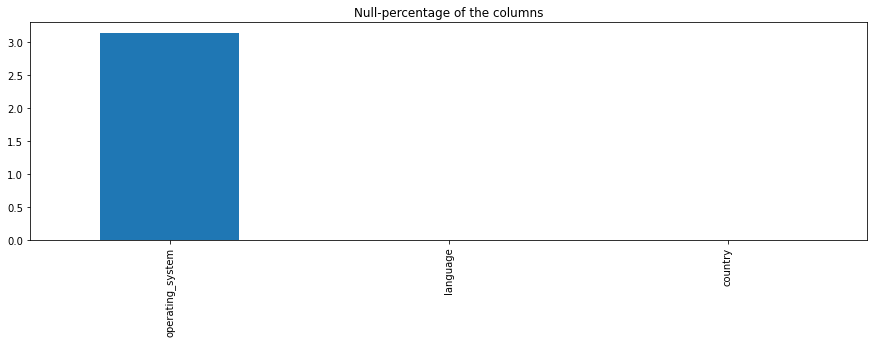

In [82]:
(100*df[["operating_system","language","country"]].isna().sum()/df.shape[0]).plot.bar(figsize=(15,4))
plt.title("Null-percentage of the columns")
plt.show()

## Training the propensity model with BigQuery ML

In this section, using the training data you prepared, you will now train machine learning models in SQL using BigQuery ML.

We will use [XGBoost](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree) model here. In this notebook, the model predicts whether the user will churn (1) or return (0) after 24 hours of the user's first engagement with the app.


#### Train an XGBoost model

The following code trains an XGBoost model. This may take several minutes to train.

For more information on the default hyperparameters used, you can read the documentation:  
[CREATE MODEL statement for Boosted Tree models using XGBoost](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree)

#@bigquery
CREATE OR REPLACE MODEL bqmlga4.churn_xgb

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  DATA_SPLIT_METHOD='RANDOM',
  DATA_SPLIT_EVAL_FRACTION=0.2,
    
  INPUT_LABEL_COLS=["churned"]
) AS

SELECT
  *
FROM
  bqmlga4.train

In [84]:
%%bigquery --project vertex-ai-dev

CREATE OR REPLACE MODEL bqmlga4.churn_xgb

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  DATA_SPLIT_METHOD='RANDOM',
  DATA_SPLIT_EVAL_FRACTION=0.2,
    
  INPUT_LABEL_COLS=["churned"]
) AS

SELECT
  *
FROM
  bqmlga4.train

Query complete after 0.00s: 100%|██████████| 3/3 [00:00<00:00, 1374.13query/s]                        


""


## Model Evaluation

To evaluate the model, you can run [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) on a model that has finished training to inspect some of the metrics.

The metrics are based on the test sample data that was automatically split during model creation ([documentation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#data_split_method)).

#@bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlga4.churn_xgb)


`ML.EVALUATE` generates the `precision`, `recall`, `accuracy` and `f1_score` using the default classification threshold of 0.5, which can be modified by using the optional [`THRESHOLD`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#eval_threshold) parameter.

Generally speaking, you can use the `log_loss` and `roc_auc` metrics to compare  model performance.

The `log_loss` ranges between 0 and 1.0, and the closer the `log_loss` is the zero, the closer the predicted labels were to the actual labels.
The `roc_auc` ranges between 0 and 1.0, and the closer the `roc_auc` is to 1.0, the better the model is at distinguishing between the classes.

For more information on these metrics, you can read through the definitions on [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall), [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy), [f1-score](https://en.wikipedia.org/wiki/F-score), [log_loss](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Logistic_loss) and [roc_auc](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

#### Confusion matrix: predicted vs actual values

In addition to model evaluation metrics, you may also want to use a confusion matrix to inspect how well the model predicted the labels, compared to the actual labels.

With the rows indicating the actual labels, and the columns as the predicted labels, the resulting format for ML.CONFUSION_MATRIX for binary classification looks like:

| | Predicted_0 | Predicted_1|
|-|-|-|
|Actual_0| True Negatives | False Positives|
|Actual_1| False Negatives | True Positives|

For more information on confusion matrices, you can read through a detailed explanation [here](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative).

#@bigquery
SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL bqmlga4.churn_xgb)

#### ROC Curve

#@bigquery
SELECT * FROM ML.ROC_CURVE(MODEL bqmlga4.churn_xgb)

## Model prediction

You can run [`ML.PREDICT`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict) to make predictions on the propensity to churn. The following code returns all the information from `ML.PREDICT`.

#@bigquery
CREATE OR REPLACE VIEW bqmlga4.prediction_data AS(
(SELECT * FROM bqmlga4.train where churned=1 limit 10)
union all
(SELECT * FROM bqmlga4.train where churned=0 limit 20))

#@bigquery
SELECT
  *
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.prediction_data)
            ) 

For propensity modeling, the most important output is the probability of a behavior occuring. The following query returns the probability that the user will return after 24 hrs. The higher the probability and closer it is to 1, the more likely the user is predicted to churn, and the closer it is to 0, the more likely the user is predicted to return.

#@bigquery
SELECT
  user_pseudo_id,
  churned,
  predicted_churned,
  predicted_churned_probs[OFFSET(0)].prob as probability_churned
  
FROM
  ML.PREDICT(MODEL bqmlga4.churn_xgb,
  (SELECT * FROM bqmlga4.train))

##### Export predictions table to Google Cloud Storage

There are several ways to export the predictions table to Google Cloud Storage (GCS), so that you can use them in a separate service. Perhaps the easiest way is to export directly to GCS using SQL ([documentation](https://cloud.google.com/bigquery/docs/reference/standard-sql/other-statements#export_data_statement)).

#@bigquery
EXPORT DATA OPTIONS (
uri="gs://gamingchurnpredictions/*.csv", 
  format=CSV,
  header=True,
  overwrite=True
    
) AS 
SELECT
  * from bqmlga4.predictions

## Clean up
<a name="section-9"></a>


To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial(The following code deletes entire dataset).


In [ ]:
# Construct a BigQuery client object.
client = bigquery.Client()

# TODO(developer): Set model_id to the ID of the model to fetch.
dataset_id = 'your-project-id.dataset-name'

# Use the delete_contents parameter to delete a dataset and its contents.
# Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
client.delete_dataset(
    dataset_id, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(dataset_id))